# Seizing the Means of Tenserflow ☭
   
## Lab Seven: Wide and Deep Network Architectures
   
### Justin Ledford, Luke Wood, Traian Pop

In [12]:
%matplotlib inline
import numpy as np
import plotly
import pandas as pd
import matplotlib.pyplot as plt
import time
import sys
import requests

import warnings
warnings.filterwarnings('ignore')

## Dataset Selection

For this project, we chose the Census-Income-MLD dataset from the UCI Machine Learning Repository due to nature of the set being exactly what we needed. The set has both categorical and integer data, a large number of attributes (40), and a very large number of instances (approximately 300,000). Not only that, but the data is also very applicable and highly wanted in our society.
   
The dataset's goal is to be able to predict whether a person, based on the values of their attributes, is under or over the 50k income bar. However, our goal for this report is not simply just accuracy. We are placing much heavier emphasis on catching false negatives in the over 50k limit section. The reason for this choise falls under the logic of marketing and advertising. Since the census is public knowledge, advertising companies tend to use it to be able to predict their target market and where they are most likely to have an affect. 
   
One target for these companies are individuals who make more than the average amount for they have more money to spend. If an advertiser is given a list that is missing a good deal of >50k individuals, they are also missing out on potential profit. This is something that our report will prioritize in order for a situation like that to be avoided.


## Preparation (40 points total)
   
### [10 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). 

In [13]:
import pandas as pd
import numpy as np
import requests


# Get column names
r = requests.get('https://raw.githubusercontent.com/LukeWoodSMU/WillBeRenamed/master/col_names.txt')

if r.status_code == 200:
    columns = r.text.replace(" ","_").replace("'","").split('\n')[:-1]
else:
    print('Error loading column names')

In [14]:
print(columns)

['age', 'class_of_worker', 'industry_code', 'occupation_code', 'education', 'wage_per_hour', 'enrolled_in_edu_inst_last_wk', 'marital_status', 'major_industry_code', 'major_occupation_code', 'race', 'hispanic_origin', 'sex', 'member_of_a_labor_union', 'reason_for_unemployment', 'full_or_part_time_employment_stat', 'capital_gains', 'capital_losses', 'dividends_from_stocks', 'tax_filer_status', 'region_of_previous_residence', 'state_of_previous_residence', 'detailed_household_and_family_stat', 'detailed_household_summary_in_household', 'migration_code-change_in_msa', 'migration_code-change_in_reg', 'migration_code-move_within_reg', 'live_in_this_house_1_year_ago', 'migration_prev_res_in_sunbelt', 'num_persons_worked_for_employer', 'family_members_under_18', 'country_of_birth_father', 'country_of_birth_mother', 'country_of_birth_self', 'citizenship', 'own_business_or_self_employed', 'fill_inc_questionnaire_for_veterans_admin', 'veterans_benefits', 'weeks_worked_in_year', 'year', 'income']

As you can see, there is a large number of attributes, with categories ranging anywhere from age to benefits. In order to ease the work on our program and receive better results, we will be crossing some of these attributes together.

In this section, we remove any attributes with missing data.

In [15]:
df_train = pd.read_csv(
        'https://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/census-income.data.gz',
        compression='gzip', header=None, index_col=False)


df_test = pd.read_csv(
        'https://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/census-income.test.gz',
        compression='gzip', header=None, index_col=False)


# Remove weight columns
df_train.drop(24, 1, inplace=True)
df_test.drop(24, 1, inplace=True)

df_train.columns = columns
df_test.columns = columns

# Remove rows with missing data and reset index
df_train.replace(to_replace=' ?',value=np.nan, inplace=True)
df_train.dropna(inplace=True)
df_train.reset_index()

df_test.replace(to_replace=' ?',value=np.nan, inplace=True)
df_test.dropna(inplace=True)
df_test.reset_index()

df_train.head()

,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_last_wk,marital_status,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veterans_admin,veterans_benefits,weeks_worked_in_year,year,income
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
6,42,Private,34,3,Bachelors degree(BA AB BS),0,Not in universe,Married-civilian spouse present,Finance insurance and real estate,Executive admin and managerial,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
9,34,Private,4,37,Some college but no degree,0,Not in universe,Married-civilian spouse present,Construction,Machine operators assmblrs & inspctrs,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.


Next, we start encoding our remaining attributes. 

In [16]:
# Process data:

# check income values consistent (only 2 values)

# replace categorical with one hot encoding
# scale continuous

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

labels = dict() 

r = requests.get('https://raw.githubusercontent.com/LukeWoodSMU/WillBeRenamed/master/categorical.txt')
categorical_labels = r.text.replace(" ","_").replace("'","").split('\n')[:-1]

for col in categorical_labels + ['income']:
    # strip extra space in strings
    if df_train[col].dtype == 'object':
        df_train[col] = df_train[col].str.strip()
    if df_test[col].dtype == 'object':
        df_test[col] = df_test[col].str.strip()
        
    # convert to ints for one hot encoder to work
    
    # keep labels for reference 
    labels[col] = list(set(df_train[col].unique()) | set(df_test[col].unique()))
    
    df_train[col].replace(to_replace=labels[col],
                            value=np.arange(len(labels[col])),
                            inplace=True)
    df_test[col].replace(to_replace=labels[col],
                            value=np.arange(len(labels[col])),
                            inplace=True)

categorical_labels

['class_of_worker',
 'industry_code',
 'occupation_code',
 'education',
 'enrolled_in_edu_inst_last_wk',
 'marital_status',
 'major_industry_code',
 'major_occupation_code',
 'race',
 'hispanic_origin',
 'sex',
 'member_of_a_labor_union',
 'reason_for_unemployment',
 'full_or_part_time_employment_stat',
 'tax_filer_status',
 'region_of_previous_residence',
 'state_of_previous_residence',
 'detailed_household_and_family_stat',
 'detailed_household_summary_in_household',
 'migration_code-change_in_msa',
 'migration_code-change_in_reg',
 'migration_code-move_within_reg',
 'live_in_this_house_1_year_ago',
 'migration_prev_res_in_sunbelt',
 'family_members_under_18',
 'country_of_birth_father',
 'country_of_birth_mother',
 'country_of_birth_self',
 'citizenship',
 'own_business_or_self_employed',
 'fill_inc_questionnaire_for_veterans_admin',
 'veterans_benefits',
 'year']

Above are our current categorical attributes.
   
Ideas for merging:
Country of birth categories too repetitive.
Industry and occupation code unreadable.

In [17]:
r = requests.get('https://raw.githubusercontent.com/LukeWoodSMU/WillBeRenamed/master/continuous.txt')
continuous_labels = r.text.replace(" ","_").replace("'","").split('\n')[:-1]


for col in continuous_labels:
    df_train[col] = df_train[col].astype(np.float32)
    df_test[col] = df_test[col].astype(np.float32)
    
    ss = StandardScaler()
    df_train[col] = ss.fit_transform(df_train[col].values.reshape(-1, 1))
    df_test[col] = ss.transform(df_test[col].values.reshape(-1, 1))
    
continuous_labels

['age',
 'wage_per_hour',
 'capital_gains',
 'capital_losses',
 'dividends_from_stocks',
 'num_persons_worked_for_employer',
 'weeks_worked_in_year']

Above are our current continuous attributes. 
   
Ideas for merging:
Turn most of these into categorical. Ranges like the Titanic dataset he showed us.

### [10 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import roc_curve, auc

# High cost for false negatives on "> 50,000" class

def weighted_recall_score(y_true, y_pred):
    """
    Weight determined by class imbalance
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    counts = np.bincount(y_true)
    weight = int(1 / (min(counts) / (sum(counts))))
    
    weight_matrix = np.array([
        [0, weight],
        [1, 0]
    ])
                 
    tp = np.sum(np.diagonal(conf_matrix))
    fn = np.sum(weight_matrix * conf_matrix)

    return tp / (tp + fn)

As mentioned above, we are focusing our score success on whether or not we can succesfully predict the false negatives in the >50k class. We implement this by overwriting the recall_score method with a confusion matrix.

### [10 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5)

df = df_train.ix[:1000].copy()
#df = df_train.copy()

X = df.drop('income', axis=1).values
y = df['income'].values

The reason we choose Stratified Shuffle Split instead of the others is due to how large our dataset is and it is the recommended one by the source where we received our data from.
___

## Modeling (50 points total)
   
### [20 points] Create a combined wide and deep network to classify your data using tensorflow.

In [20]:
import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.contrib import layers
from tensorflow.contrib.learn.python import SKCompat
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib
tf.logging.set_verbosity(tf.logging.WARN) # control the verbosity of tensor flow

In [21]:
# Let's start with the TF example (manipulated to work with new syntax)
# https://www.tensorflow.org/tutorials/wide_and_deep
def process_input(df, label_header, categ_headers, numeric_headers):
    # input: what ever you need it to be
    # output: (dict of feature columns as tensors), (labels as tensors)
    
    # ========Process Inputs=========
    # Creates a dictionary mapping from each continuous feature column name (k) to
    # the values of that column stored in a constant Tensor.
    continuous_cols = {k: tf.expand_dims( # make it a column vector
                            tf.cast( # cast to a float32
                                tf.constant(df[k].values), 
                                tf.float32), 
                            1)
                       for k in numeric_headers}
    
    # Creates a dictionary mapping from each categorical feature column name (k)
    # to the values of that column stored as constant Tensors (numeric)
    # then use tensor flow to one hot encode them using the given number of classes 
    # name of encoder is **_int need to map only to **
    categorical_cols = {k: tf.one_hot(indices=tf.constant(df[k].values),
                                      depth=len(labels[k])) 
                        for k in categ_headers}
    
    # Merges the two dictionaries into one.
    feature_cols = dict(continuous_cols)
    feature_cols.update(categorical_cols)
    
    # Convert the label column into a constant Tensor.
    label = None
    if label_header is not None:
        label = tf.constant(df[label_header].values)
        
    return feature_cols, label

In [22]:
# update the model to take input features as a dictionary
def MLP(dict_features, targets, mode):
    # the prototype for this function is as follows
    # input:  (features, targets) 
    # output: (predictions, loss, train_op)
    
    #=======DECODE FEATURES================
    # now let's combine the tensors from the input dictionary
    # into a list of the feature columns
    features = [dict_features[x] for x in continuous_labels+categorical_labels]
   
    # also add in the one hot encoded features
    for col in categorical_labels:
        features.append(dict_features[col])
    
    # now we can just combine all the features together
    features = tf.concat(values=features,axis=1)
    
    # =====SETUP ARCHITECTURE=====
    # we can use functions from learn to add layers and complexity to the model
    # pass features through one hidden layer with relu activation
    features = layers.relu(features, num_outputs=50) 
    # now pass the features through a fully connected layer
    features = layers.fully_connected(features, num_outputs=1) 
    # and pass them through a sigmoid activation
    output_layer = tf.sigmoid(features) 
    # reshape the output to be one dimensional
    predictions = tf.reshape(output_layer, [-1])
    
    # depending on the mode, we may not want to evaluate these
    loss_mse = None
    train_op = None
    
    # Calculate Loss (for both TRAIN and EVAL modes)
    if mode != learn.ModeKeys.INFER:
        # =====LOSS=======
        # we want to use MSE as our loss function
        loss_mse = tf.losses.mean_squared_error(targets, predictions) 
    
    if mode == learn.ModeKeys.TRAIN:
        # =====OPTIMIZER PARAMS========
        # now let's setup how we want thing to optimize 
        train_op = layers.optimize_loss(
            loss=loss_mse, 
            global_step=tf.contrib.framework.get_global_step(),
            optimizer='Adagrad', # adaptive gradient, so that the learning rate is not SO important 
            learning_rate=0.1)
    
    # what format to have the output in when calling clf.predict?
    predictions_out = predictions>0.5
    
    return model_fn_lib.ModelFnOps(
      mode=mode, predictions={'incomes':predictions_out}, loss=loss_mse, train_op=train_op)


In [23]:
%%time

mlp_rocs = []

for train_index, test_index in sss.split(X, y):
    clf = learn.Estimator(model_fn=MLP)

    # when we provide the process function, they expect us to control the mini-batch
    clf.fit(input_fn=
                lambda:process_input(df.iloc[train_index], 'income',categorical_labels, continuous_labels), 
                steps=500)
    
    y_test = df['income'].iloc[test_index]

    yhat = clf.predict(input_fn=
                       lambda:process_input(df.iloc[test_index], None,categorical_labels, continuous_labels))
    # the output is now an iterable value, so we need to step over it
    yhat = [x['incomes'] for x in yhat]
    print(confusion_matrix(y_test,yhat),
          weighted_recall_score(y_test,yhat))
    
    #mlp_rocs.append(roc_curve(y_test, clf.predict_proba()))

[[  3  12]
 [  0 217]] 0.55
[[  3  12]
 [  2 215]] 0.545
[[  4  11]
 [  4 213]] 0.562176165803
[[  7   8]
 [  2 215]] 0.645348837209
[[  2  13]
 [  0 217]] 0.528985507246
CPU times: user 40.7 s, sys: 1.8 s, total: 42.5 s
Wall time: 27.7 s


### [20 points] Investigate generalization performance by altering the number of layers. Try at least two different deep network architectures. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab.

### Cross Columns

In [24]:
# https://www.tensorflow.org/tutorials/wide_and_deep
def process_input_cc(df, label_header, categ_headers, numeric_headers):
    # input: what ever you need it to be
    # output: (dict of feature columns as tensors), (labels as tensors)
    
    # ========Process Inputs=========
    # not much changes here, except we leave the numerics as tc.constants
    continuous_cols = {k: tf.reshape(tf.constant(df[k].values), [-1]) for k in numeric_headers}
      
    # and we shift these tensors to be sparse one-hot encoded values
    # Creates a dictionary mapping from each categorical feature column name (k)
    # to the values of that column stored in a tf.SparseTensor.
    categorical_cols = {k: tf.SparseTensor(
                              indices=[[i, 0] for i in range(df[k].size)],
                              values=df[k].astype(str).values,
                              dense_shape=[df[k].size, 1])
                        for k in categ_headers}
    
    # Merges the two dictionaries into one.
    feature_cols = dict(categorical_cols)
    feature_cols.update(continuous_cols)
    
    # Convert the label column into a constant Tensor.
    label = None
    if label_header is not None:
        label = tf.constant(df[label_header].values)
        
    return feature_cols, label

In [25]:
# update the model to take input features as a dictionary
def setup_wide_deep_columns():
    # the prototype for this function is as follows
    # input:  (features, targets) 
    # output: (predictions, loss, train_op)
    
    wide_columns = []
    deep_columns = []
    # add in each of the categorical columns to both wide and deep features
    for col in categorical_labels:
        wide_columns.append(
            layers.sparse_column_with_keys(col, keys=[str(x) for x in labels[col]])
        )
        
        dim = round(np.log2(len(labels[col]))) + 1
        deep_columns.append(
            layers.embedding_column(wide_columns[-1], dimension=dim)
        )
        
    # also add in some specific crossed columns
    cross_columns = [('education','occupation_code'),('country_of_birth_father', 'country_of_birth_mother')]
    for tup in cross_columns:
        wide_columns.append(
            layers.crossed_column(
                [layers.sparse_column_with_keys(tup[0], keys=[str(x) for x in labels[tup[0]]]),
                 layers.sparse_column_with_keys(tup[1], keys=[str(x) for x in labels[tup[1]]])],
            hash_bucket_size=int(1e4))
        )
        
        
    # and add in the regular dense features 
    for col in continuous_labels:
        deep_columns.append(
            layers.real_valued_column(col)
        )
                    
    return wide_columns, deep_columns

In [26]:
%%time

tf.logging.set_verbosity(tf.logging.ERROR)

df = df_train.ix[:2000].copy()
#df = df_train.copy()

X = df.drop('income', axis=1).values
y = df['income'].values

wide_columns, deep_columns = setup_wide_deep_columns()

for col in deep_columns:
    if col.dimension == 0.0:
        print(col)

dnn_roc_auc = []

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5)

for train_index, test_index in sss.split(X, y):
    clf = learn.DNNLinearCombinedClassifier(
                            linear_feature_columns=wide_columns,
                            dnn_feature_columns=deep_columns,
                            dnn_hidden_units=[100, 50, 25, 5])

    input_wrapper = lambda:process_input_cc(df.iloc[train_index],'income',categorical_labels, continuous_labels)
    output_wrapper = lambda:process_input_cc(df.iloc[test_index],None,categorical_labels, continuous_labels)

    # when we provide the process function, they expect us to control the mini-batch
    clf.fit(input_fn=input_wrapper, steps=500)

    y_test = df['income'].iloc[test_index]

    yhat = clf.predict(input_fn=output_wrapper)

    # the output is now an iterable value, so we need to step over it
    yhat = [x for x in yhat]

    print(confusion_matrix(y_test,yhat),
          accuracy_score(y_test,yhat))
    
    probs = list(clf.predict_proba(input_fn=output_wrapper))
    probs = np.array(probs)[:,1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    dnn_roc_auc.append((fpr, tpr, auc(fpr, tpr)))

[[  2  24]
 [  1 458]] 0.948453608247
[[  7  19]
 [  0 459]] 0.960824742268
[[  5  21]
 [  2 457]] 0.952577319588
[[  3  23]
 [  0 459]] 0.952577319588
[[  3  23]
 [  0 459]] 0.952577319588
CPU times: user 10min 1s, sys: 38.3 s, total: 10min 40s
Wall time: 10min 22s


### 10 points] Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve.

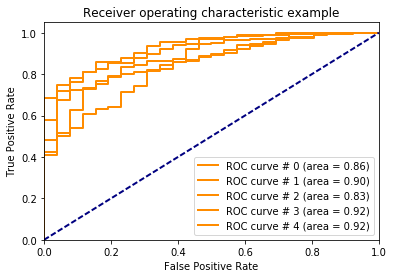

In [27]:
plt.figure()
lw = 2
i = 0
for fpr, tpr, auc_ in dnn_roc_auc:
        plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve # %d (area = %0.2f)' % (i, auc_))
        i += 1
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

___

## Exceptional Work (10 points total)
   
### One idea: Investigate which cross-product features are most important and hypothesize why.
___